In [1]:
import torch
from torch import nn #contains all of PyTorch's neural network building blocks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("PyTorch version:", torch.__version__)
print("Number of CUDA devices: ", torch.cuda.device_count())

PyTorch version: 2.1.0+cu121
Number of CUDA devices:  0


In [2]:
'''
PyTorch Workflow:
1. Preparing and Loading Data
2. Building the Model
3. Fitting Model to Data (Training)
4. Making Predictions and Model Evaluation (Inference)
5. Saving and Loading Model
6. Putting it All Together
'''

'\nPyTorch Workflow:\n1. Preparing and Loading Data\n2. Building the Model\n3. Fitting Model to Data (Training)\n4. Making Predictions and Model Evaluation (Inference)\n5. Saving and Loading Model\n6. Putting it All Together\n'

In [3]:
#1. Preparing and Loading Data

#create known parameters
weight = 0.7
bias = 0.3

print(type(weight), type(bias))
start = 0
end = 2.01
step = 0.05
X = torch.arange(start, end, step).unsqueeze(dim=1)
y=weight*X+bias
X[10:20], y[10:20]

#split into train and test data
#Best practices: 60-80% allocated as training data, 10-20% - validation data, and 10-20% - test data.
train_split = int(len(X)*0.8) #80% of training data allocated
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] #20% of training data allocated as testing data
print("Size of X:", len(X))
print("X_train size:",len(X_train), "\ny_train size:",len(y_train), "\nX_test size:",len(X_test), "\ny_test size:", len(y_test))

<class 'float'> <class 'float'>
Size of X: 41
X_train size: 32 
y_train size: 32 
X_test size: 9 
y_test size: 9


In [4]:
#initialize device, include device-agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


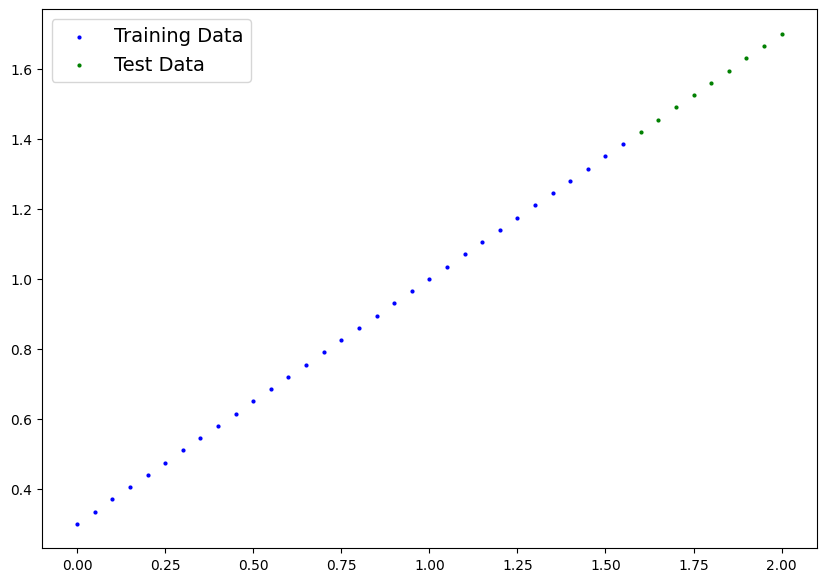

In [5]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None, title=None):

  plt.figure(figsize=(10, 7))
  #plot training data in blue
  plt.scatter(train_data, train_labels, color='blue', s=4, label="Training Data")
  plt.scatter(test_data, test_labels, color='green', s=4, label="Test Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, color='red', s=4, label="Predictions")
  plt.title(title)
  plt.legend(prop={"size": 14})

  plt.show()

plot_predictions()


In [6]:
#build model

#PyTorch Model-Building Essentials
#torch.nn - contains all of the building blocks for constructing neural networks in PyTorch, computational graphs
#torch.nn.Module - base class for all neural network modules, if subclassed (like in below model), forward must be overridden
#torch.nn.Parameter - defines parameters for neural network model to learn, often PyTorch layer from torch.nn will set this for us
#torch.optim - contains optimizer algorithms for optimizing parameters, helps with gradient descent
#def forward() - defines what happens in the forward computations of the neural network, all nn.Module subclasses require overriding forward method
from torch import nn
#create linear regression model class, inherits from nn.Module, which almost everything in PyTorch inherits from nn

#model_0
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) #<- start with random weight and try to adjust to ideal weight
    self.bias=nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) #<- start with random bias and try to adjust to ideal bias

  def forward(self, x: torch.Tensor) -> torch.Tensor: #x is our input data
    return self.weights*x+self.bias #linear regression

#model_1
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #use nn.Linear() to create model parameters, also called linear transform/probing layer/fully connected layer/dense layer (TensorFlow)
    self.linear_layer=nn.Linear(in_features=1, out_features=1, dtype=torch.float32)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)
#our goal is to try and get our model to get as close to our pre-selected weight and bias as possible by starting with random values for them
#model is evaluated by how close our model gets these random values to the actual weight and bias

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
print("Initial model 0 weight parameter:", list(model_0.parameters())[0][0].item(),
      "\nInitial model 0 bias parameter:", list(model_0.parameters())[1][0].item())

torch.manual_seed(42)
model_1 =LinearRegressionModelV2()

print("Initial model 1 weight parameter:", list(model_1.parameters())[0][0].item(),
      "\nInitial model 1 bias parameter:", list(model_1.parameters())[1][0].item())

print("Desired model weight parameter:", weight,
      "\nDesired model bias parameter:", bias)

Initial model 0 weight parameter: 0.33669036626815796 
Initial model 0 bias parameter: 0.12880940735340118
Initial model 1 weight parameter: 0.7645385265350342 
Initial model 1 bias parameter: 0.8300079107284546
Desired model weight parameter: 0.7 
Desired model bias parameter: 0.3


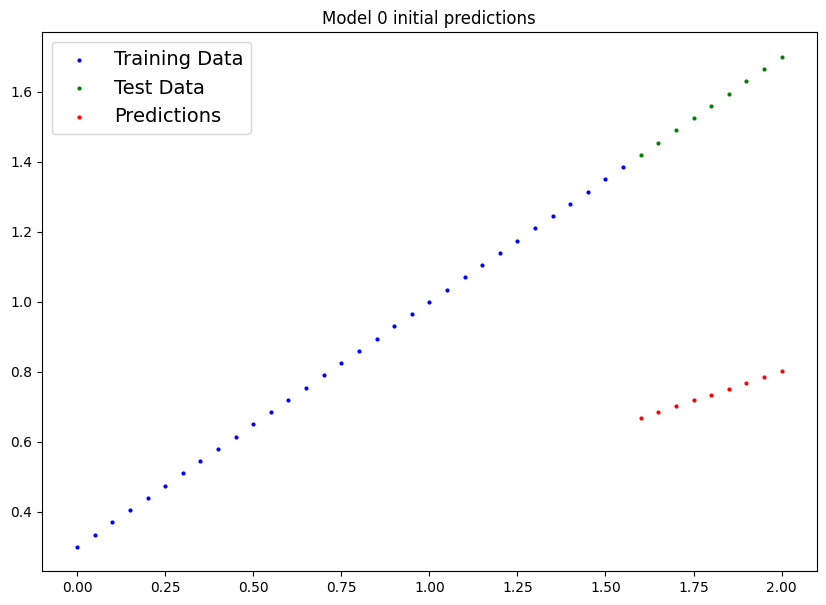

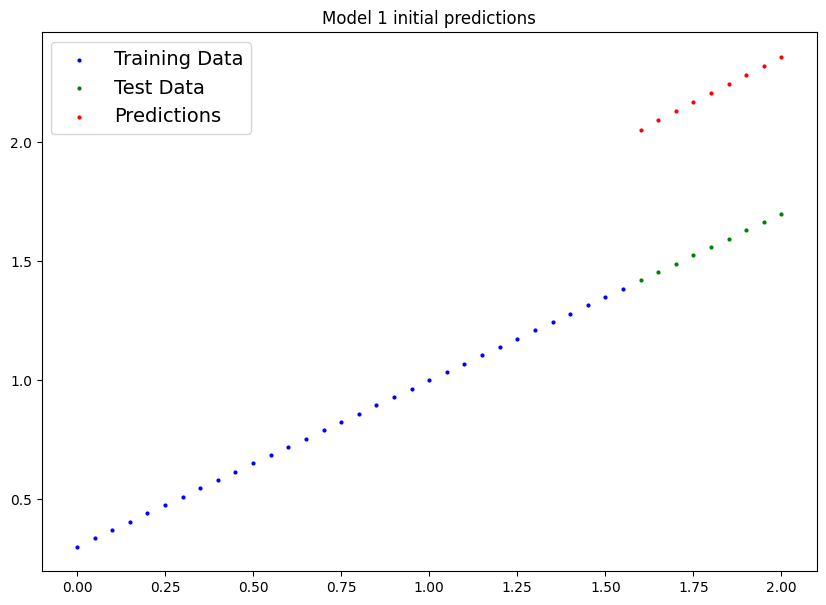

In [8]:
#torch.inference_model() for making predictions without updating weights and biases from gradient descent
#use to quickly prototype and obtain results using fixed parameters for weights and bias

#ensure models are on current device
model_0.to(device)
model_1.to(device)

with torch.inference_mode():
  y_preds_0 = model_0(X_test)
  y_preds_1 = model_1(X_test)

plot_predictions(predictions=y_preds_0, title="Model 0 initial predictions")
plot_predictions(predictions=y_preds_1, title="Model 1 initial predictions")
#pretty poor model 0 performance at the moment



In [9]:
#Optimizer and Loss Function

#set up loss function - L1Loss (calculates MAE), good for linear regression. For classification, we may want to use binary cross-entropy loss
loss_func = nn.L1Loss()
loss_func1 = nn.L1Loss()
#set up optimizer - stochastic gradient descent (SGD)
optimizer0 = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer1 = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [11]:
#ONLY RUN WHEN FINDING OPTIMAL # EPOCHS FOR SUBSEQUENT TRAINING
#Building a Training Loop
import matplotlib.pyplot as plt

#loop through data (1 loop = 1 epoch)
losses = []
losses1 = []
weights = []
weights1 = []
biases = []
biases1 = []
test_losses = []
test_losses1 = []
epochs=500

#use to test ideal # of epochs for both models, set epochs to as large as desired
for epoch in range(epochs):
  model_0.train() #train mode in pytorch set
  model_1.train()
  #1. forward pass on train data using forward() method in model class
  y_pred=model_0(X_train)
  y_pred1=model_1(X_train)
  #2. calculate loss (how different model values - inputs - are compared to the true values - targets)
  loss=loss_func(y_pred, y_train)
  loss1=loss_func1(y_pred1, y_train)

  #optimizer zero grad - zero gradients of optimizer to prevent accumulation of gradients from prior steps
  optimizer0.zero_grad()
  optimizer1.zero_grad()

  #backpropagation - perform backpropagation to feed loss function into optimizer to step down loss function towards trough (bottom)
  loss.backward()
  loss1.backward()
  #step optimizer - perform gradient descent by optimizing loss function and stepping down it
  optimizer0.step()
  optimizer1.step()

  model_0.eval() #turns off settings not pertinent to testing/evaluation, use when predicting
  model_1.eval()
  if(epoch%10==0):
    print("Model 0 parameters:",model_0.state_dict())
    print("Model 1 parameters:",model_1.state_dict())

  losses.append(loss.item())  # Assuming loss is a scalar tensor
  losses1.append(loss1.item())

  weights.append(model_0.state_dict()['weights'].clone().detach().numpy())
  biases.append(model_0.state_dict()['bias'].clone().detach().numpy())

  weights1.append(model_1.state_dict()['linear_layer.weight'].clone().detach().numpy())
  biases1.append(model_1.state_dict()['linear_layer.bias'].clone().detach().numpy())

  with torch.inference_mode(): #testing evaluations per epoch
    test_preds=model_0(X_test)
    test_preds1=model_1(X_test)

    test_loss=loss_func(test_preds, y_test)
    test_loss1=loss_func(test_preds1, y_test)

    test_losses.append(test_loss.item())
    test_losses1.append(test_loss1.item())
    if(epoch%10==0):
      print("Model 0 --", "Epoch #", epoch, ": Training loss:", loss, "Test loss:", test_loss)
      print("Model 1 --", "Epoch #", epoch, ": Training loss:", loss1, "Test loss:", test_loss1)

Model 0 parameters: OrderedDict([('weights', tensor([0.3444])), ('bias', tensor([0.1388]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7568]])), ('linear_layer.bias', tensor([0.8200]))])
Model 0 -- Epoch # 0 : Training loss: tensor(0.4528, grad_fn=<MeanBackward0>) Test loss: tensor(0.8012)
Model 1 -- Epoch # 0 : Training loss: tensor(0.5800, grad_fn=<MeanBackward0>) Test loss: tensor(0.6222)
Model 0 parameters: OrderedDict([('weights', tensor([0.3522])), ('bias', tensor([0.1488]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7490]])), ('linear_layer.bias', tensor([0.8100]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3599])), ('bias', tensor([0.1588]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7413]])), ('linear_layer.bias', tensor([0.8000]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3677])), ('bias', tensor([0.1688]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', ten

Losses Model 0: [0.45275557041168213, 0.43674930930137634, 0.42074304819107056, 0.40473678708076477, 0.388730525970459, 0.3727242648601532, 0.3567180037498474, 0.340711772441864, 0.3247055113315582, 0.30869925022125244, 0.29269295930862427, 0.2766866981983185, 0.2606804668903351, 0.2446741908788681, 0.2286679446697235, 0.2126617133617401, 0.1966554820537567, 0.18064922094345093, 0.1651935577392578, 0.15085959434509277, 0.13762670755386353, 0.12547311186790466, 0.11437491327524185, 0.10430500656366348, 0.09523232281208038, 0.08712058514356613, 0.07992750406265259, 0.0736243948340416, 0.0677604079246521, 0.06272917240858078, 0.05846431851387024, 0.05488963425159454, 0.05191788077354431, 0.04944996163249016, 0.047413937747478485, 0.04558634012937546, 0.044038645923137665, 0.042774587869644165, 0.04151293262839317, 0.04047534614801407, 0.03943774849176407, 0.038400158286094666, 0.03739866614341736, 0.03646809980273247, 0.03553752973675728, 0.034606970846652985, 0.0336763858795166, 0.032745

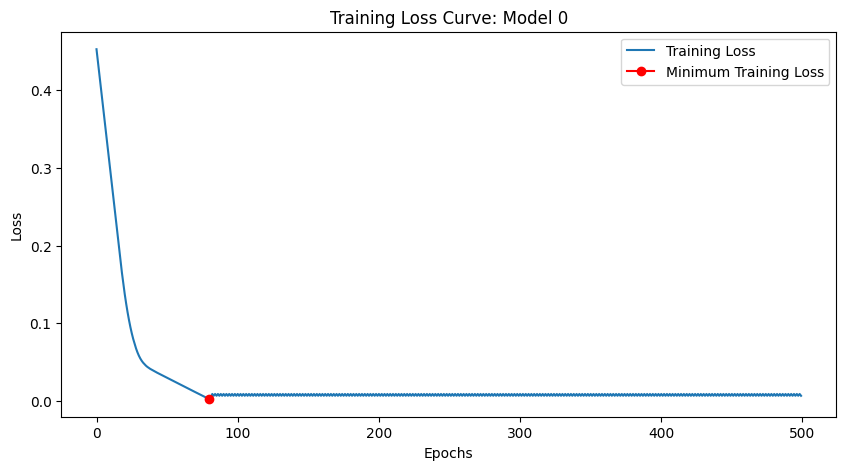

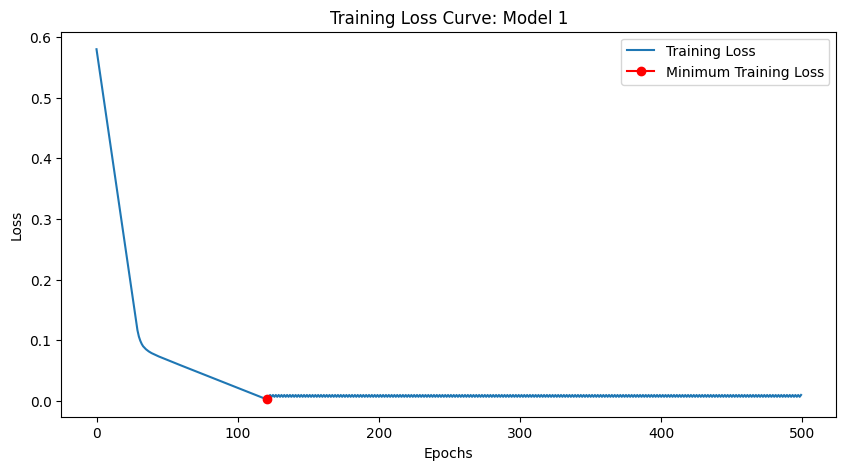

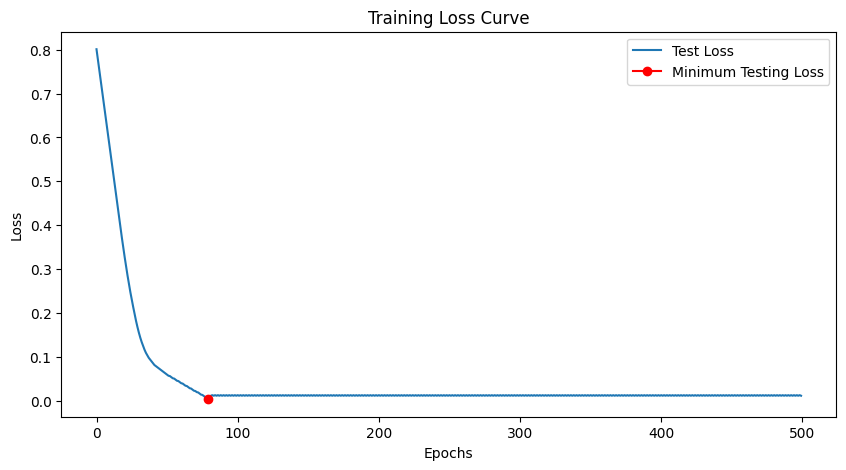

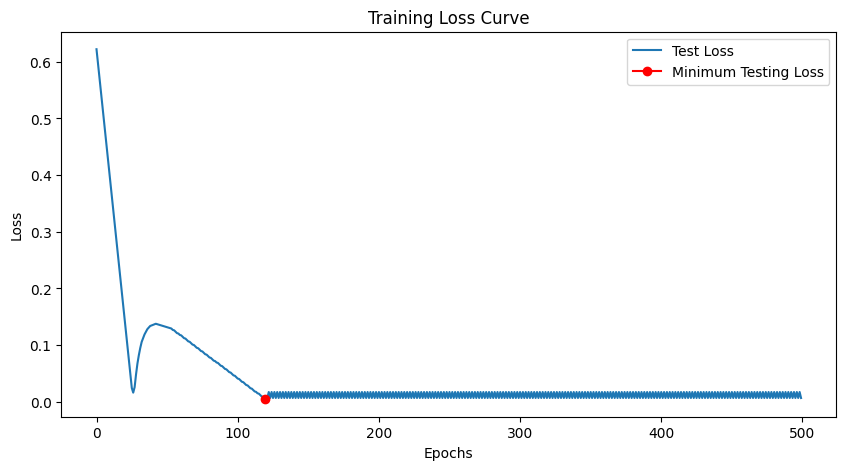

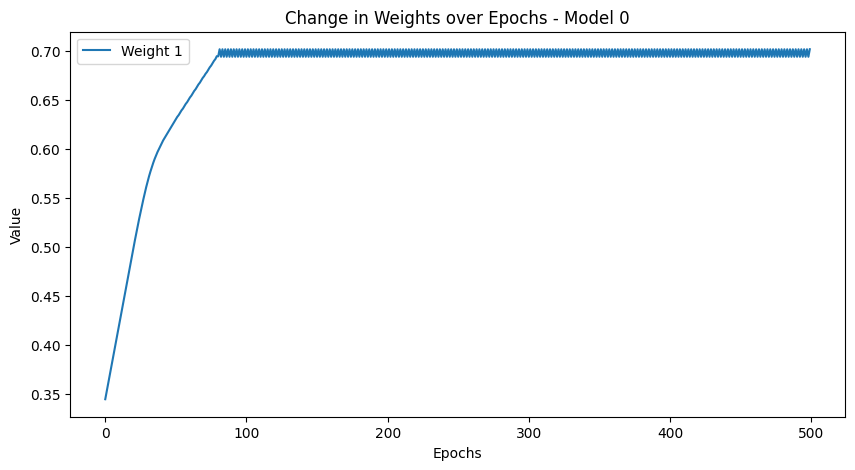

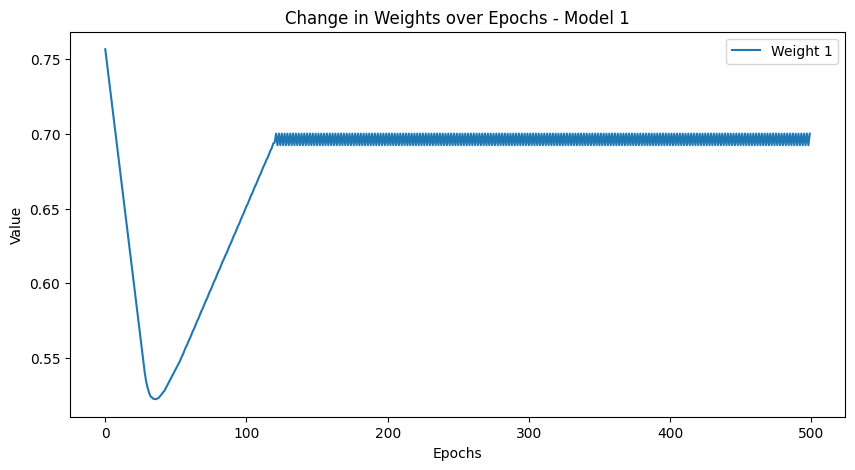

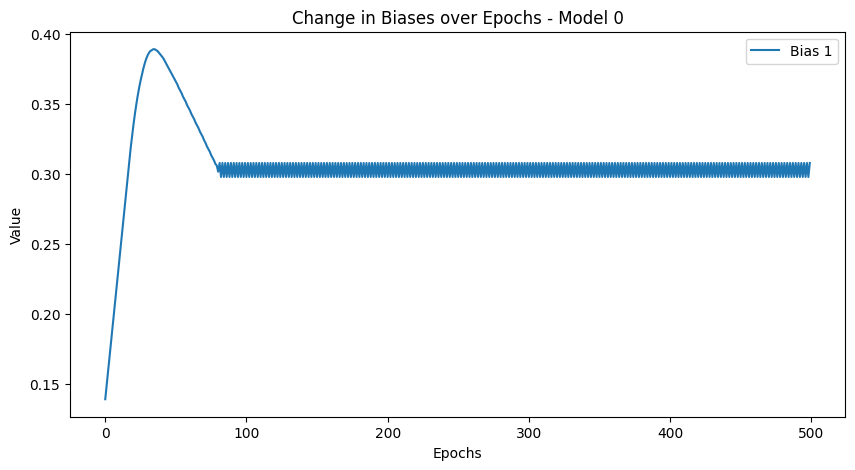

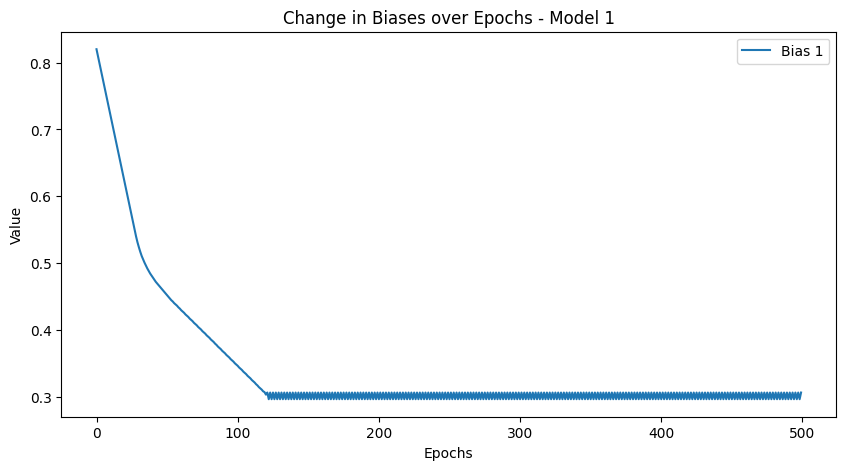

Model 0:
Min training loss epoch: 80
0.0024082548916339874
Min testing loss epoch: 79
0.0033673446159809828
[0.69481516]
[0.30130914]
Model 1:
Min training loss epoch: 121
0.0025217337533831596
Min testing loss epoch: 119
0.0045213038101792336
[[0.700227]]
[0.30625767]


In [12]:
print("Losses Model 0:",losses)
print("Test losses Model 0:", test_losses)
print("Weights Model 0:",weights)
print("Biases Model 0:",biases)

print("Losses Model 1:",losses1)
print("Test losses Model 1:", test_losses1)
print("Weights Model 1:",weights1)
print("Biases Model 1:",biases1)

min_loss = np.min(losses)
min_test_loss = np.min(test_losses)

min_loss1 = np.min(losses1)
min_test_loss1 = np.min(test_losses1)

# Plotting Training Loss Curve - Model 0
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label='Training Loss')
plt.plot(np.argmin(losses), min_loss, marker='o', color='red', label='Minimum Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve: Model 0')
plt.legend()
plt.show()

# Plotting Training Loss Curve - Model 1
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses1, label='Training Loss')
plt.plot(np.argmin(losses1), min_loss1, marker='o', color='red', label='Minimum Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve: Model 1')
plt.legend()
plt.show()

#Plotting Testing Loss Curve - Model 0
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.plot(np.argmin(test_losses), min_test_loss, marker='o', color='red', label='Minimum Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

#Plotting Testing Loss Curve - Model 1
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), test_losses1, label='Test Loss')
plt.plot(np.argmin(test_losses1), min_test_loss1, marker='o', color='red', label='Minimum Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Plotting Weights and Biases - Model 0
weights = np.array(weights)
biases = np.array(biases)

# Plotting Weights and Biases - Model 1
weights1 = np.array(weights1)
biases1 = np.array(biases1)

plt.figure(figsize=(10, 5))
for i in range(weights.shape[1]):
    plt.plot(range(epochs), weights[:, i], label=f'Weight {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Change in Weights over Epochs - Model 0')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(weights1.shape[1]):
    plt.plot(range(epochs), weights1[:, i], label=f'Weight {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Change in Weights over Epochs - Model 1')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(biases.shape[1]):
    plt.plot(range(epochs), biases[:, i], label=f'Bias {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Change in Biases over Epochs - Model 0')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(biases1.shape[1]):
    plt.plot(range(epochs), biases1[:, i], label=f'Bias {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Change in Biases over Epochs - Model 1')
plt.legend()
plt.show()

#show best parameters, epoch(s) of best parameters
print("Model 0:")
print("Min training loss epoch:", np.argmin(losses))
print(losses[np.argmin(losses)])
print("Min testing loss epoch:", np.argmin(test_losses))
print(test_losses[np.argmin(test_losses)])
print(weights[np.argmin(losses)])
print(biases[np.argmin(losses)])


print("Model 1:")
print("Min training loss epoch:", np.argmin(losses1))
print(losses1[np.argmin(losses1)])
print("Min testing loss epoch:", np.argmin(test_losses1))
print(test_losses1[np.argmin(test_losses1)])
print(weights1[np.argmin(losses1)])
print(biases1[np.argmin(losses1)])

In [10]:
#once lowest errors and ideal epochs found, restart kernel and run training from here
import matplotlib.pyplot as plt

#loop through data (1 loop = 1 epoch)
losses = []
losses1 = []
weights = []
weights1 = []
biases = []
biases1 = []
test_losses = []
test_losses1 = []
epochs0=81

for epoch in range(epochs0):
  #set train mode
  model_0.train()

  #train model, pass trained data to y_preds
  y_preds=model_0(X_train)

  #initialize local loss function
  loss=loss_func(y_preds, y_train)

  #set gradient to 0 for optimizer
  optimizer0.zero_grad()

  #backpropagate loss
  loss.backward()

  #optimizer step
  optimizer0.step()

  model_0.eval() #turns off settings not pertinent to testing/evaluation, use when predicting

  print("Model 0 parameters:",model_0.state_dict())


  losses.append(loss.item())  # Assuming loss is a scalar tensor

  weights.append(model_0.state_dict()['weights'].clone().detach().numpy())
  biases.append(model_0.state_dict()['bias'].clone().detach().numpy())

  with torch.inference_mode(): #testing evaluations per epoch
    test_preds=model_0(X_test)

    test_loss=loss_func(test_preds, y_test)

    test_losses.append(test_loss.item())
    if(epoch%10==0):
      print("Model 0 --", "Epoch #", epoch, ": Training loss:", loss, "Test loss:", test_loss)


Model 0 parameters: OrderedDict([('weights', tensor([0.3444])), ('bias', tensor([0.1388]))])
Model 0 -- Epoch # 0 : Training loss: tensor(0.4528, grad_fn=<MeanBackward0>) Test loss: tensor(0.8012)
Model 0 parameters: OrderedDict([('weights', tensor([0.3522])), ('bias', tensor([0.1488]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3599])), ('bias', tensor([0.1588]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3677])), ('bias', tensor([0.1688]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3754])), ('bias', tensor([0.1788]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3832])), ('bias', tensor([0.1888]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3909])), ('bias', tensor([0.1988]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.3987])), ('bias', tensor([0.2088]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.4064])), ('bias', tensor([0.2188]))])
Model 0 parameters: OrderedDict([('weights', tensor([0.4142

In [12]:
epochs1=120
for epoch in range(epochs1):
  #set train mode
  model_1.train()

  #train model, pass trained data to y_preds
  y_preds1=model_1(X_train)

  #initialize local loss function
  loss1=loss_func1(y_preds1, y_train)

  #set gradient to 0 for optimizer
  optimizer1.zero_grad()

  #backpropagate loss
  loss1.backward()

  #optimizer step
  optimizer1.step()

  model_1.eval() #turns off settings not pertinent to testing/evaluation, use when predicting

  print("Model 1 parameters:",model_1.state_dict())


  losses1.append(loss1.item())  # Assuming loss is a scalar tensor

  weights1.append(model_1.state_dict()['linear_layer.weight'].clone().detach().numpy())
  biases1.append(model_1.state_dict()['linear_layer.bias'].clone().detach().numpy())

  with torch.inference_mode(): #testing evaluations per epoch
    test_preds1=model_1(X_test)

    test_loss1=loss_func1(test_preds1, y_test)

    test_losses1.append(test_loss.item())
    if(epoch%10==0):
      print("Model 0 --", "Epoch #", epoch, ": Training loss:", loss, "Test loss:", test_loss)


Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7568]])), ('linear_layer.bias', tensor([0.8200]))])
Model 0 -- Epoch # 0 : Training loss: tensor(0.0024, grad_fn=<MeanBackward0>) Test loss: tensor(0.0080)
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7490]])), ('linear_layer.bias', tensor([0.8100]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7413]])), ('linear_layer.bias', tensor([0.8000]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7335]])), ('linear_layer.bias', tensor([0.7900]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7258]])), ('linear_layer.bias', tensor([0.7800]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7180]])), ('linear_layer.bias', tensor([0.7700]))])
Model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.7103]])), ('linear_layer.bias', tensor([0.7600]))])
Model 1 parameters: OrderedDict([('linear_layer.weight',

Model 0 Summary:
Ideal weights: 0.7 
Ideal bias: 0.3 
Weights after training: 0.6948151588439941 
Bias after training: 0.30130913853645325


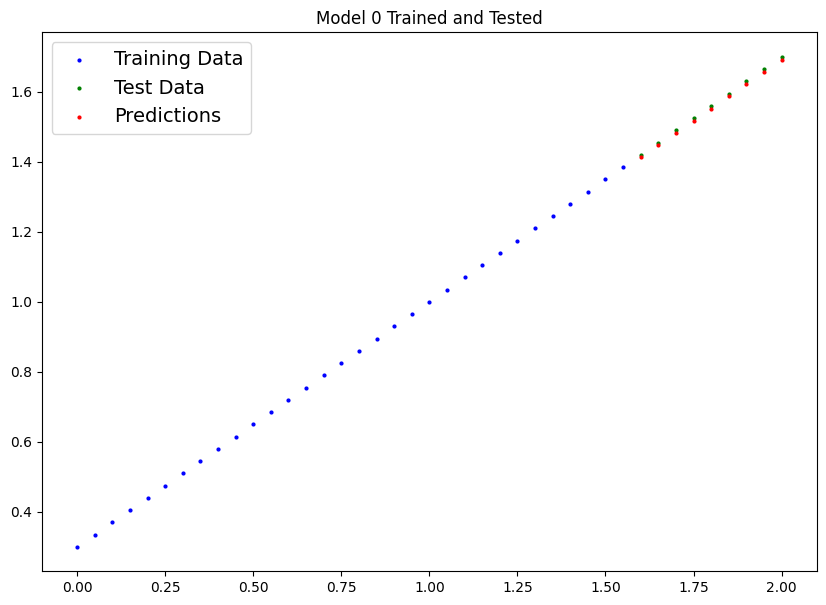

Model 1 Summary:
Ideal weights: 0.7 
Ideal bias: 0.3 
Weights after training: 0.6936644911766052 
Bias after training: 0.3068826496601105


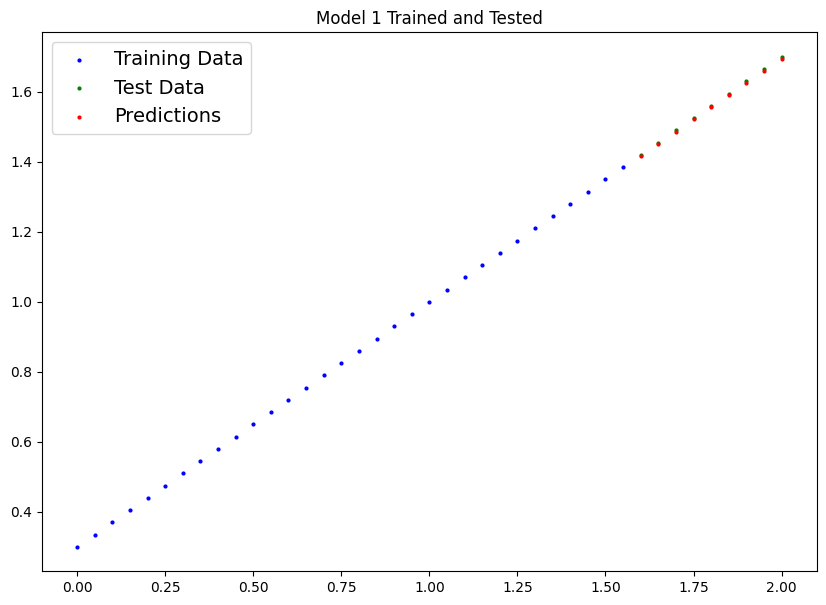

In [14]:
with torch.inference_mode():
  y_preds_new=model_0(X_test)
model_0.state_dict()
print("Model 0 Summary:")
print("Ideal weights:", weight, "\nIdeal bias:", bias, "\nWeights after training:", model_0.state_dict()['weights'].item(),
      "\nBias after training:", model_0.state_dict()['bias'].item())
plot_predictions(predictions=test_preds, title="Model 0 Trained and Tested")
#MUCH better!

with torch.inference_mode():
  y_preds_new1=model_1(X_test)
model_1.state_dict()
print("Model 1 Summary:")
print("Ideal weights:", weight, "\nIdeal bias:", bias, "\nWeights after training:", model_1.state_dict()['linear_layer.weight'].item(),
      "\nBias after training:", model_1.state_dict()['linear_layer.bias'].item())
plot_predictions(predictions=test_preds1, title="Model 1 Trained and Tested")
#MUCH better!

In [15]:
#Saving a model

#torch.save() - leverages Python 'pickling' to serialize model or any pytorch data construct to byte stream and save in database or file
#torch.load() - leverages Python 'depickling' to unserialize model or pytorch data construct to load and use as model
#torch.nn.Module.load_state_dict() - allows to load a model's saved state dictionary (parameters)

from pathlib import Path

#create model directory
MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#create model save path
MODEL_NAME0='workflow_LinearRegModel.pth'
MODEL_SAVE_PATH0=MODEL_PATH/MODEL_NAME0
MODEL_SAVE_PATH0

#save model state_dict
print(f"Saving model to {MODEL_SAVE_PATH0}...")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH0)

Saving model to models/workflow_LinearRegModel.pth...


In [16]:
#create model save path
MODEL_NAME1='workflow_LinearRegModelV2.pth'
MODEL_SAVE_PATH1=MODEL_PATH/MODEL_NAME1
MODEL_SAVE_PATH1

#save model state_dict
print(f"Saving model to {MODEL_SAVE_PATH1}...")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH1)

Saving model to models/workflow_LinearRegModelV2.pth...


In [17]:
#load model

#to load in a saved state dict, we must first instantiate a variable with the model class
loaded_model_0 = LinearRegressionModel()

#load saved state dict to parametrize loaded model 0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH0))

print("Loaded model 0 parameters:",loaded_model_0.state_dict())

#to load in a saved state dict, we must first instantiate a variable with the model class
loaded_model_1 = LinearRegressionModelV2()

#load saved state dict to parametrize loaded model 0
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH1))

print("Loaded model 1 parameters:",loaded_model_1.state_dict())

Loaded model 0 parameters: OrderedDict([('weights', tensor([0.6948])), ('bias', tensor([0.3013]))])
Loaded model 1 parameters: OrderedDict([('linear_layer.weight', tensor([[0.6937]])), ('linear_layer.bias', tensor([0.3069]))])
